# Modelo para classificar relevância dos artigos do DOU
## Seção 2

Dado um conjunto de artigos do DOU classificados pela equipe na escala de 1 a 5 em relevância, vamos criar um modelo de machine learning para dar notas a novos artigos.

In [1]:
import pandas as pd
import utils as xu
import datetime as dt
import re
import numpy as np
import matplotlib.pyplot as pl
import mltools as ml
from importlib import reload

## Carrega os dados

Os dados são classificados diariamente pela equipe, e vai parar numa tabela do BigQuery. 
Nós podemos pegar, a cada dia, um número maior de artigos classificados.

### Cortes nos dados

Ao longo do processo de classificação manual, os critérios para seleção inicial dos artigos foram mudando. Aqui nós aplicamos os critétios mais atualizados para homogeneizar os dados selecionados.

In [2]:
query_1_cuts = """
secao = 1
AND (
     LOWER(identifica) LIKE '%decreto%' 
  OR LOWER(identifica) LIKE '%portaria%' 
  OR LOWER(identifica) LIKE '%resolu%'
  OR LOWER(identifica) LIKE '%medida provisória%'
  OR LOWER(identifica) LIKE '%lei %'
)
AND NOT REGEXP_CONTAINS(LOWER(edicao), '-')
AND (LOWER(orgao) NOT LIKE '%universidade%' AND LOWER(orgao) NOT LIKE '%instituto federal%')
AND (LOWER(orgao) NOT LIKE '%superintendência regional%')
AND (LOWER(orgao) NOT LIKE '%gerência regional%')
AND (LOWER(orgao) NOT LIKE '%superintendência estadual%' AND LOWER(orgao) NOT LIKE '%colégio%')
AND SPLIT(orgao, '/')[OFFSET(0)] 
  NOT IN ('Conselho Nacional do Ministério Público', 
          'Entidades de Fiscalização do Exercício das Profissões Liberais', 'Governo do Estado', 'Ineditoriais', 
          'Defensoria Pública da União', 'Ministério Público da União', 'Poder Judiciário', 'Prefeituras', 
          'Tribunal de Contas da União', 'Atos do Poder Judiciário')
AND orgao 
  NOT IN ('Conselho Nacional do Ministério Público', 
          'Entidades de Fiscalização do Exercício das Profissões Liberais', 'Governo do Estado', 'Ineditoriais', 
          'Defensoria Pública da União', 'Ministério Público da União', 'Poder Judiciário', 'Prefeituras', 
          'Tribunal de Contas da União', 'Atos do Poder Judiciário')
AND (orgao NOT LIKE '%Coordenação de Processos Migratórios%')
AND (orgao NOT LIKE '%Secretaria de Fomento e Incentivo à Cultura%')
AND (orgao NOT LIKE '%Departamento de Radiodifusão Comercial%')
"""

In [3]:
query_2_cuts = """
secao = 2
AND NOT REGEXP_CONTAINS(LOWER(edicao), '-')
AND (LOWER(orgao) NOT LIKE '%universidade%' AND LOWER(orgao) NOT LIKE '%instituto federal%')
AND (LOWER(orgao) NOT LIKE '%superintendência regional%')
AND (LOWER(orgao) NOT LIKE '%gerência regional%')
AND (LOWER(orgao) NOT LIKE '%superintendência estadual%' AND LOWER(orgao) NOT LIKE '%colégio%')
AND SPLIT(orgao, '/')[OFFSET(0)] 
  NOT IN ('Conselho Nacional do Ministério Público', 
          'Entidades de Fiscalização do Exercício das Profissões Liberais', 'Governo do Estado', 'Ineditoriais', 
          'Defensoria Pública da União', 'Ministério Público da União', 'Poder Judiciário', 'Prefeituras', 
          'Tribunal de Contas da União', 'Atos do Poder Judiciário', 'Poder Legislativo')
AND orgao 
  NOT IN ('Conselho Nacional do Ministério Público', 
          'Entidades de Fiscalização do Exercício das Profissões Liberais', 'Governo do Estado', 'Ineditoriais', 
          'Defensoria Pública da União', 'Ministério Público da União', 'Poder Judiciário', 'Prefeituras', 
          'Tribunal de Contas da União', 'Atos do Poder Judiciário', 'Poder Legislativo')
AND (LOWER(orgao) NOT LIKE '%comando militar%')
AND (LOWER(orgao) NOT LIKE '%hospital%')
AND LOWER(fulltext) NOT LIKE '%conceder aposentadoria%' AND LOWER(fulltext) NOT LIKE '%aposentar%'
AND LOWER(fulltext) NOT LIKE '%conceder pensão%' 
AND LOWER(fulltext) NOT LIKE '%afastamento do país%'
"""

In [4]:
query_3_cuts = """
secao = 3
AND NOT REGEXP_CONTAINS(LOWER(edicao), '-')
AND (LOWER(orgao) NOT LIKE '%universidade%' AND LOWER(orgao) NOT LIKE '%instituto federal%')
AND (LOWER(orgao) NOT LIKE '%superintendência regional%')
AND (LOWER(orgao) NOT LIKE '%gerência regional%')
AND (LOWER(orgao) NOT LIKE '%superintendência estadual%' AND LOWER(orgao) NOT LIKE '%colégio%')
AND SPLIT(orgao, '/')[OFFSET(0)] 
  NOT IN ('Conselho Nacional do Ministério Público', 
          'Entidades de Fiscalização do Exercício das Profissões Liberais', 'Governo do Estado', 'Ineditoriais', 
          'Defensoria Pública da União', 'Ministério Público da União', 'Poder Judiciário', 'Prefeituras', 
          'Tribunal de Contas da União', 'Atos do Poder Judiciário')
AND orgao 
  NOT IN ('Conselho Nacional do Ministério Público', 
          'Entidades de Fiscalização do Exercício das Profissões Liberais', 'Governo do Estado', 'Ineditoriais', 
          'Defensoria Pública da União', 'Ministério Público da União', 'Poder Judiciário', 'Prefeituras', 
          'Tribunal de Contas da União', 'Atos do Poder Judiciário')
"""

In [5]:
query_e_cuts = """
REGEXP_CONTAINS(LOWER(edicao), '-')
AND (LOWER(orgao) NOT LIKE '%universidade%' AND LOWER(orgao) NOT LIKE '%instituto federal%')
AND (LOWER(orgao) NOT LIKE '%superintendência regional%')
AND (LOWER(orgao) NOT LIKE '%gerência regional%')
AND (LOWER(orgao) NOT LIKE '%superintendência estadual%' AND LOWER(orgao) NOT LIKE '%colégio%')
AND SPLIT(orgao, '/')[OFFSET(0)] 
  NOT IN ('Conselho Nacional do Ministério Público', 
          'Entidades de Fiscalização do Exercício das Profissões Liberais', 'Governo do Estado', 'Ineditoriais', 
          'Defensoria Pública da União', 'Ministério Público da União', 'Poder Judiciário', 'Prefeituras', 
          'Tribunal de Contas da União', 'Atos do Poder Judiciário')
AND orgao 
  NOT IN ('Conselho Nacional do Ministério Público', 
          'Entidades de Fiscalização do Exercício das Profissões Liberais', 'Governo do Estado', 'Ineditoriais', 
          'Defensoria Pública da União', 'Ministério Público da União', 'Poder Judiciário', 'Prefeituras', 
          'Tribunal de Contas da União', 'Atos do Poder Judiciário')
"""

In [6]:
base_query = "SELECT * FROM `gabinete-compartilhado.executivo_federal_dou.artigos_classificados`"
query_cuts = '('+ ') OR ('.join([query_1_cuts, query_2_cuts, query_3_cuts, query_e_cuts]) + ')'

get_classified_query = base_query + ' WHERE ' + query_cuts

### Carregando nossa classificação

Esta é a classificação de relevância das matérias do DOU, feitas pela equipe. A célula descomentada atualiza os dados com as novas classificações feitas e guardadas no nosso banco de dados. Para acessar dados antigos e já baixados, utilize a célula comentada que aparece logo em seguida.

In [8]:
today    = dt.datetime.now().strftime('%Y-%m-%d')
filename = '../dados/artigos_classificados_ate_' + today + '.csv'
print(xu.Bold('Arquivo com dados de hoje:'), filename)

Arquivo com dados de hoje: ../dados/artigos_classificados_ate_2021-09-17.csv


In [9]:
classified_raw = xu.load_data_from_local_or_bigquery(get_classified_query, filename)

Loading data from local file...


In [7]:
# Para carregar classificações feitas até uma certa data:
#classified_raw = pd.read_csv('../dados/artigos_classificados_ate_2021-09-17.csv')

In [11]:
n_null_url    = len(classified_raw.loc[classified_raw.url.isnull()])
frac_null_url = n_null_url / len(classified_raw)
print('Found', n_null_url, 'missing URLs in data ({:.1f}%)'.format(frac_null_url * 100))
print(xu.Bold('These will be removed!'))

Found 0 missing URLs in data (0.0%)
These will be removed!


In [12]:
# We removed articles without urls because they shouldn't exist and we 
# will use urls as identifiers.
classified_w_url = classified_raw.loc[~classified_raw.url.isnull()]
print('Dados disponíveis:', len(classified_w_url))

Dados disponíveis: 14442


In [13]:
# Frequência de cada relevância na amostra classificada pela equipe:
dou_class_freq = classified_w_url.relevancia.value_counts(normalize=True)
dou_class_freq

1    0.520219
2    0.250519
3    0.097355
4    0.080114
5    0.051793
Name: relevancia, dtype: float64

## Selecionando seção e train validation test split

Precisamos fazer o split por data, para que o modelo seja treinado para prever o futuro.

In [14]:
# Select seção 1 and define a set splitting date:
secao = 2
min_test_date = '2021-03-13'

# Seleciona a seção:
classified_secao = classified_w_url.loc[classified_w_url.secao == secao]

# Split data into training, validation and test sets:
#train_raw, val_raw, test_raw = ml.train_val_test_split_by_date_n_string(classified_secao, 'data_pub', 
#                                                                        min_test_date, 
#                                                                        'url', 'http://www.in.gov.br/web/dou/-/')

# Randomly split dataset:
build_raw, test_raw = ml.train_test_split_by_string(classified_secao, 0.15, 'url', 'http://www.in.gov.br/web/dou/-/')
train_raw, val_raw  = ml.train_test_split_by_string(build_raw, 0.17, 'url', 'http://www.in.gov.br/')

In [15]:
# Check the amount of each class in each set:
n_ex_by_relevancia = pd.DataFrame()
n_ex_by_relevancia['train'] = train_raw.relevancia.value_counts()
n_ex_by_relevancia['val']   = val_raw.relevancia.value_counts()
n_ex_by_relevancia['test']  = test_raw.relevancia.value_counts()
assert n_ex_by_relevancia.isna().any().any() == False, 'Some set has missing classes'
n_ex_by_relevancia.sort_index()

,train,val,test
1,3245,653,668
2,1646,363,333
3,474,80,100
4,392,79,84
5,294,70,72


## Modelagem

Design do modelo

### Construção da pipeline

In [16]:
# Preprocessing:
import dou_sorter_common_functions as do
# Model evaluation:
import dou_model_eval as ev

In [17]:
import nltk
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

In [18]:
# Pré-processamento (s/ fit):
text_col = 'tit_org_ementa_text'
colunas_relevantes = ['relevancia', 'tipo_edicao'] + [text_col]

stopwords = nltk.corpus.stopwords.words('portuguese')

dou_extractor = do.PreprocessDOU(colunas_relevantes, 'xxnuloxx')

proc_text = do.PreProcessText(cargo_tokens=True, lowercase=True, remove_punctuation=True, keep_cash=True, 
                              stopwords=stopwords, stemmer=None, strip_accents=False, only_letters=False,
                              text_cols=[text_col])

preprocess = Pipeline([('dou', dou_extractor), ('pretext', proc_text)])

# Keywords to give extra weights:
keywords = ['superior', 'Ceder', 'Assessor', 'Coordenador-Geral', 'EDUCAÇÃO', 'MEIO AMBIENTE', 'Tecnologia da Informação', 
            'Pessoa com Deficiência', 'TURISMO', 'Cultura', 'Mulheres', 'Chefe de Gabinete', 
            'Igualdade Racial', 'xxcaiixx', 'xxcaixx', 'xxcddoisxx', 'xxcdtxx', 'xxcgeiiixx', 
            'xxcgeiixx', 'xxcgeivxx', 'xxcgeixx', 'xxcnexx', 'xxdascincoxx', 'xxdasdoisxx', 
            'xxdasquatroxx', 'xxdasseisxx', 'xxdastresxx', 'xxdasumxx', 'xxfcpecincoxx', 'xxfcpedoisxx', 
            'xxfcpequatroxx', 'xxfcpetresxx', 'xxfcpeumxx', 'xxnaturezaespecialxx', 
            'xxnaturezaespecialxx xxnexx', 'xxnexx', 'substituto', 'substituta', 'substituir', 
            'Diretor', 'Secretário', 'Diretora', 'Secretária', 'Superintendente-Geral', 
            'Superintendente Regional', 'Gerente Regional', 'cargo de Secretário', 'cargo de Secretária',
            'comissão de Secretário', 'comissão de Secretária', 'comissionada de Secretário', 
            'comissionada de Secretária', 'cargo de Diretor', 'cargo de Diretora',
            'comissão de Diretor', 'comissão de Diretora', 'comissionada de Diretor', 
            'comissionada de Diretora', 'cargo de Ministro', 'cargo de Ministra', 'comissionado de Secretário',
            'comissionado de Secretária', 'cargo de Coordenador-Geral', 'comissionado de Coordenador-Geral',
            'comissão de Coordenador-Geral', 'cargo de Assessor', 'comissionado de Assessor', 
            'comissão de Assessor', 'cargo de Assessora', 'comissionado de Assessora', 'comissão de Assessora']
#keywords = ['xxdasdoisxx', 'xxdastresxx', 'xxdasumxx', 'xxfcpedoisxx', 'xxfcpetresxx', 'xxfcpeumxx', 
#            'substituto','substituta', 'substituir', 'substituto eventual', 'substituta eventual'] # 0.925 
#anti_keywords = ['cargo', 'ambiente', 'comissão', 'comissionada', 'educação', 'gabinete', 'meio', 'pessoa', 
#                 'Tecnologia', 'Tecnologia da', 'da Informação', 'Pessoa com', 'Igualdade', 'geral',
#                 'cargo de', 'regional', 'comissão de', 'comissionada de', 'comissionado', 'comissionado de',
#                 'eventual']
anti_keywords = ['cargo']
keywords_df        = pd.DataFrame({text_col: keywords})
anti_keywords_df   = pd.DataFrame({text_col: anti_keywords})
proc_keywords      = list(proc_text.transform(keywords_df)[text_col].values)
proc_anti_keywords = list(proc_text.transform(anti_keywords_df)[text_col].values)

# Fit processing and model:
vectorizer    = CountVectorizer(lowercase=False, binary=True, ngram_range=(1,1), max_df=0.7, min_df=2)
#vectorizer    = ml.WeightedVectorizer(lowercase=False, binary=True, ngram_range=(1,1), max_df=0.7, min_df=2,
#                                      keywords=proc_keywords, anti_keywords=proc_anti_keywords, keywords_weight=10)
#vectorizer    = TfidfVectorizer(lowercase=False, binary=True, ngram_range=(1,1), max_df=0.6, min_df=1)

encoder_extra = OneHotEncoder(drop='first')
processor     = ColumnTransformer([('vec',   vectorizer,    text_col),
                                   ('extra', encoder_extra, ['tipo_edicao'])
                                  ])

#classifier  = ElasticNet(alpha=0.023, l1_ratio=0.4, selection='random', max_iter=5000)
#classifier  = Ridge(30)
#classifier  = HuberRegressor(max_iter=1000, epsilon=2.2)
#classifier  = SVR(kernel='rbf', C=30, gamma=0.004786827/3)
#classifier  = SVR(kernel='poly', degree=2, C=1, coef0=2)
#classifier  = SVR(kernel='sigmoid', gamma=0.004786827/3, C=30, coef0=-1)
#classifier  = DecisionTreeRegressor(min_samples_split=8, min_samples_leaf=2, max_depth=29)
#classifier  = RandomForestRegressor(max_depth=30, min_samples_split=2, n_estimators=20, min_samples_leaf=1, max_samples=0.9, n_jobs=7)
#classifier  = Lasso(0.03, max_iter=4000, selection='random', tol=1e-4)
#classifier  = Lasso(0.003, max_iter=4000, selection='random', tol=1e-4)
#classifier = BaggingRegressor(Ridge(30), n_estimators=400, bootstrap=False)
#classifier = VotingRegressor([('svm_rbf', SVR(kernel='rbf', C=10, gamma=0.004786827/3)), 
#                              ('svm_poly', SVR(kernel='poly', degree=2, C=1, coef0=2)),
#                              ('svm_log', SVR(kernel='sigmoid', gamma=0.004786827/3, C=30, coef0=-1))])
classifier = VotingRegressor([('ridge', Ridge(30)), 
                              #('svr', SVR(C=100, gamma=0.004786827)), 
                              ('forest', RandomForestRegressor(max_depth=25, min_samples_split=2, n_estimators=20, min_samples_leaf=1, max_samples=0.7, n_jobs=7))
                             ])
#classifier = AdaBoostRegressor(Ridge(1))
#classifier  = MLPRegressor(hidden_layer_sizes=(4,), solver='lbfgs', max_iter=500, alpha=80, random_state=5871)
fit_pipe    = Pipeline([('proc', processor), ('fit', classifier)])

In [19]:
# Instance weights:
def relevance2weight(y):
    return y 

### Aplica pipeline ao dados

In [20]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.base import clone

#### Busca nos hiperparâmetros

In [21]:
# Create a CV set and pre-process it:
train_val_concat = pd.concat([train_raw, val_raw], sort=False)
#train_val_concat = pd.concat([aumented_train_raw, val_raw], sort=False)
proc_train_val   = preprocess.transform(train_val_concat)

In [272]:
param_grid = [{#'fit__alpha': [2,4,8,16,32,64], # Ridge
               #'fit__hidden_layer_sizes': [(4,), (8,), (12,), (16,)]
               #'proc__vec__keywords_weight': [0.1, 0.3, 1, 3, 10, 100, 1000]
               #'fit__alpha': [10, 30, 100, 300, 1000.0], # Huber
               #'fit__epsilon': [3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7] # Huber
               #'fit__base_estimator__alpha': [1, 2, 5, 1e1, 2e1, 5e1, 1e2, 2e2, 5e2, 1e3, 2e3, 5e3, 1e4], #Bagging.
               #'fit__max_features': [0.01, 0.03, 0.1, 0.3, 0.6, 0.9], # Bagging.
               #'fit__C': [3, 10, 30, 100, 300, 1000], # SVR
               #'fit__coef0': [-1.5, -1, -0.5, 0],
               #'fit__gamma': [0.004786827 * 3, 0.004786827, 0.004786827/3],
               #'fit__alpha': [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1], # Lasso
               #'fit__l1_ratio': [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01],
               #'proc__vec__max_df': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
               #'proc__vec__max_df': [1.0],
               #'proc__vec__use_idf': [True, False],
               #'proc__vec__norm': ['l1', 'l2', None],
               #'proc__vec__smooth_idf': [True, False],
               #'proc__vec__sublinear_tf':[True, False],
               #'proc__vec__min_df': [1, 2, 4, 6, 8, 10],
               #'proc__vec__ngram_range': [(1,1), (1,2)],
               #'proc__vec__binary': [True, False],
              #'proc__vec__ngram_range': [(1,1)],
              #'proc__extra': ['drop', encoder_extra],
              #'proc__extra': ['drop'],
               #'proc__vec__keywords_weight': [1, 3, 10, 30, 100]
             }]

#param_grid = [{'fit__max_depth':[None, 5, 10, ],
#               'fit__min_samples_split':[2,4,8,16,32],
#               'fit__min_samples_leaf':[1,2,4,8,16],
               #'fit__max_features': ['auto', 'sqrt'],
#               'fit__max_samples': [0.3, 0.5, 0.7, 0.9, 1.0],
#               'fit__n_estimators': [20]
               #'proc__vec__max_df': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
               #'proc__vec__min_df': [1, 2, 4, 6, 8, 10],
               #'proc__vec__ngram_range': [(1,1), (1,2)],               
               #'proc__vec__binary': [True, False]#,
              #'proc__vec__keywords_weight': [1, 3, 10, 30, 100]
#             }]

#param_grid = {'fit__forest__max_depth':[None, 15, 20, 25, 30],
#               'fit__forest__min_samples_split':[2, 4, 8, 16, 32],
#               'fit__forest__n_estimators': [8, 14, 20],
#               'fit__ridge__alpha': [10, 30, 100, 300],
#              'proc__vec__max_df': [0.2, 0.4, 0.6, 0.8, 1.0],
               #'proc__vec__ngram_range': [(1,1), (1,2)],
#               'fit__forest__max_samples': [0.3, 0.5, 0.7, 0.9, 1.0],
#               'fit__svr__gamma': ['scale', 0.004786827/3],
#               'proc__vec__max_df': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
#               'proc__vec__keywords_weight': [1, 2, 5, 10, 20, 50, 100, 200]
#             }

#param_grid = {'fit__forest__max_depth':[4, 5, 6, 7, 8, 9, 10],
#               'fit__forest__min_samples_split':[2,3,4,5],
#               'fit__forest__n_estimators': [10, 11, 12, 13, 14],
#               'fit__ridge__alpha': [20, 40, 80, 100, 200, 400],
#               'fit__svr__C': [3, 10, 30, 100, 300],
#               'fit__mlp__alpha': [30, 100, 200, 600],
#               'proc__vec__max_df': [0.2, 0.3, 0.4, 0.5, 0.6],
#               'proc__vec__keywords_weight': [1, 2, 5, 10, 20, 50],
#             }

#param_grid = {'fit__alpha': [3e-1, 1, 3, 10, 30]}

rank_scorer = make_scorer(ev.cum_recall_metric, greater_is_better=True)

# Do a Grid or Randomized search with fixed validation set:
test_fold = np.zeros(len(train_val_concat)).astype(int)
#test_fold[:len(aumented_train_raw)] = -1
test_fold[:len(train_raw)] = -1
ps = PredefinedSplit(test_fold)
#grid = GridSearchCV(fit_pipe, param_grid, cv=ps, scoring=rank_scorer, return_train_score=True, n_jobs=7)
#grid = GridSearchCV(fit_pipe, param_grid, cv=ps, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=7)
grid = RandomizedSearchCV(fit_pipe, param_grid, cv=ps, scoring=rank_scorer, return_train_score=True, n_jobs=7, n_iter=100)
#grid = RandomizedSearchCV(fit_pipe, param_grid, cv=ps, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=7, n_iter=100)

In [273]:
# Run the hyper parameter search:
dump = grid.fit(proc_train_val, proc_train_val.relevancia.values, fit__sample_weight=relevance2weight(proc_train_val.relevancia.values))

print('Best score:', grid.best_score_)
print('Params:', grid.best_params_)

/home/skems/system/envs/gabi/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best score: 0.9313413625080447
Params: {'fit__gamma': 0.004786827, 'fit__C': 300}


In [241]:
# Run the hyper parameter search:
dump = grid.fit(proc_train_val, proc_train_val.relevancia.values, fit__sample_weight=relevance2weight(proc_train_val.relevancia.values))

print('Best score:', grid.best_score_)
print('Params:', grid.best_params_)

Best score: 0.9510771965309063
Params: {'proc__vec__ngram_range': (1, 1), 'proc__vec__max_df': 0.6, 'proc__vec__keywords_weight': 100, 'fit__ridge__alpha': 100, 'fit__forest__n_estimators': 14, 'fit__forest__min_samples_split': 2, 'fit__forest__max_samples': 0.7, 'fit__forest__max_depth': None}


In [275]:
# Listagem dos melhores resultados:
grid_df = pd.DataFrame(grid.cv_results_)
target_cols = ['mean_test_score', 'mean_fit_time', 'mean_train_score']
param_cols  = list(filter(lambda s: s.find('param_') != -1, grid_df.columns))
grid_df.sort_values(target_cols, ascending=[False, True, False])[target_cols + param_cols].head(20)

,mean_test_score,mean_fit_time,mean_train_score,param_fit__gamma,param_fit__C
16,0.931341,34.006826,0.999860,0.00478683,1000
13,0.931341,38.758348,0.999860,0.00478683,300
10,0.931256,39.110413,0.999890,0.00478683,100
2,0.930545,32.865455,0.981652,0.00159561,3
1,0.929221,33.590481,0.996501,0.00478683,3
7,0.929074,38.911501,0.999896,0.00478683,30
8,0.927590,40.432717,0.999225,0.00159561,30
4,0.927443,36.100304,0.999735,0.00478683,10
6,0.927198,32.821050,0.999932,0.0143605,30
15,0.927174,29.133579,0.999942,0.0143605,1000


/home/skems/prog/my-python/mltools.py:1651: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)


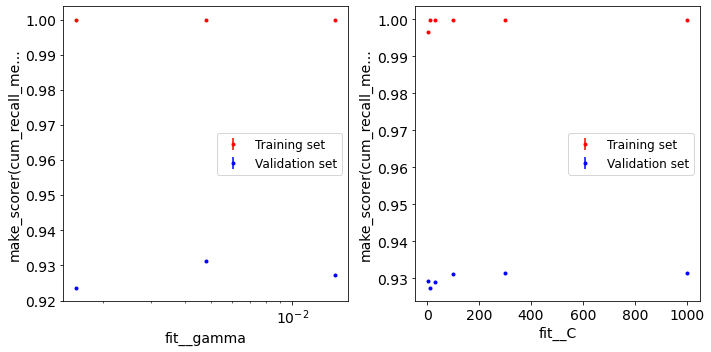

In [274]:
ml.plot_pars_scores(grid)

#### Avaliação do modelo

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
# Preprocess data:
#proc_train = preprocess.transform(aumented_train_raw)
proc_train = preprocess.transform(train_raw)
proc_val   = preprocess.transform(val_raw)

In [24]:
# Fit model:
fit_pipe.fit(proc_train, proc_train.relevancia.values, fit__sample_weight=relevance2weight(proc_train.relevancia.values))
# Predict:
pred_train = fit_pipe.predict(proc_train)
pred_val   = fit_pipe.predict(proc_val)

# Join validation true and predicted values:
y_pred_true_df = pd.DataFrame({'y_pred':pred_val, 'y_true': proc_val['relevancia'].values}, index=proc_val.index)

In [26]:
print('RMSE:       ', np.sqrt(mean_squared_error(proc_val.relevancia.values, pred_val)))
print('Cum. Recall:', ev.cum_recall_metric(proc_val.relevancia.values, pred_val))

RMSE:        0.7068610327005216
Cum. Recall: 0.9436045835806014


In [27]:
# Cria pesos para amostragem balançeada:
n_val = len(proc_val)
n_balanced_sample = (dou_class_freq * n_val).round().astype(int) / y_pred_true_df['y_true'].value_counts()
n_balanced_sample = n_balanced_sample.rename('n_balanced')

# Junta pesos à base:
y_pred_true_to_sample = y_pred_true_df.join(n_balanced_sample, on='y_true', how='left')

# Mede performance em amostras bootstrap:
n_trials = 10
rmse_list      = []
cumrecall_list = []
for i in range(n_trials):
    balanced_sample = y_pred_true_to_sample.sample(n=n_val, replace=True, weights='n_balanced')
    rmse_list.append(np.sqrt(mean_squared_error(balanced_sample.y_true.values, balanced_sample.y_pred.values)))
    cumrecall_list.append(np.sqrt(ev.cum_recall_metric(balanced_sample.y_true.values, balanced_sample.y_pred.values)))

# Resultados:
print('RMSE:       ', ml.mean_dev_scores(rmse_list))
print('Cum. Recall:', ml.mean_dev_scores(cumrecall_list))

RMSE:        (0.7115248217551087, 0.013584061839303486)
Cum. Recall: (0.9663620898018703, 0.003587979237485388)


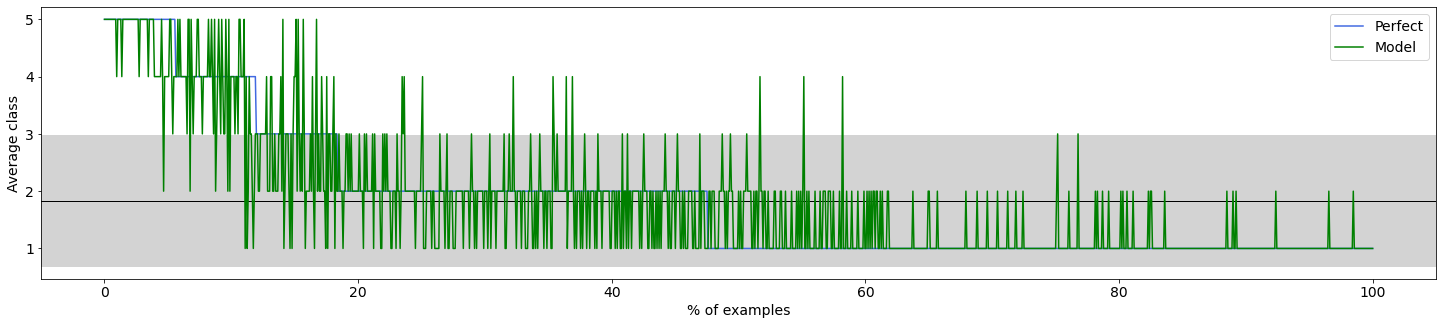

In [28]:
window = 1

pl.figure(figsize=(25,5))
ev.plot_average_rank(proc_val['relevancia'].values, proc_val['relevancia'].values, window, 
                  color='royalblue', label='Perfect')
ev.plot_average_rank(proc_val['relevancia'].values, pred_val, window, color='g', label='Model')
pl.legend(fontsize=14)
pl.show()

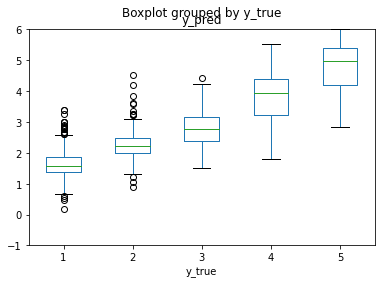

In [29]:
y_pred_true_df.boxplot(column='y_pred', by='y_true', grid=False)
#pl.savefig('plots/box-plot_rank_by_true_label_' + dt.datetime.now().strftime('%Y-%m-%d') + '.png')
pl.ylim([-1,6])
pl.show()

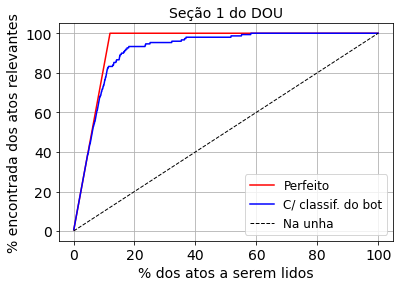

In [30]:
ev.plot_recall_curve(proc_val.relevancia.values, pred_val)

In [31]:
y_pred_true_df.loc[y_pred_true_df.y_true.isin([4,5])]['y_pred'].min()

1.8011930074852862

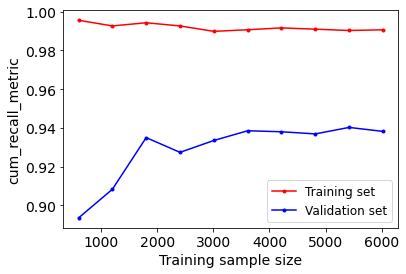

In [297]:
ml.plot_learning_curve_old(fit_pipe, ev.cum_recall_metric, proc_train, proc_train.relevancia.values,
                           proc_val, proc_val.relevancia.values, 10)

#### Peso das palavras

In [164]:
def get_ensemble_member(ensemble, member):
    """
    Return the specified model `member` (str) in a voting or transformer `ensemble` 
    (sklearn ensemble model or Column transformer).
    """
    
    try:
        # If `ensemble` is a transformer:
        members_list = ensemble.transformers_
        sel = list(filter(lambda t: t[0] == member, members_list))
        return sel[0][1]
    except:
        try:
            # If `ensemble` is an estimator:
            members_dict = ensemble.named_estimators_
            sel = members_dict[member]
            return sel
        except ValueError:
            # None of the above:
            return ValueError
        
    
    

In [165]:
def get_pipeline_member(pipeline, members):
    """
    Return the member of a `pipeline` nested under labels given 
    by `members` (list of str).
    
    Ex: get_pipeline_member(pipeline, ['proc', 'vec'])
    """
    step = pipeline[members[0]]
    if len(members) == 1:
        return step
    
    return get_ensemble_member(step, members[1])

In [166]:
# Cria um dataframe de palavras e pesos (exclui a feature de tipo de edição, Extra ou não):
vec    = get_pipeline_member(fit_pipe, ['proc', 'vec'])
ridge  = get_pipeline_member(fit_pipe, ['fit', 'ridge'])
forest = get_pipeline_member(fit_pipe, ['fit', 'forest'])
word_weight_df = pd.DataFrame()
word_weight_df['word']   = pd.Series(vec.get_feature_names())
word_weight_df['weight'] = pd.Series(ridge.coef_[:-1])
word_weight_df['abs_weight'] = np.abs(word_weight_df['weight'])
word_weight_df['importance'] = pd.Series(forest.feature_importances_[:-1])

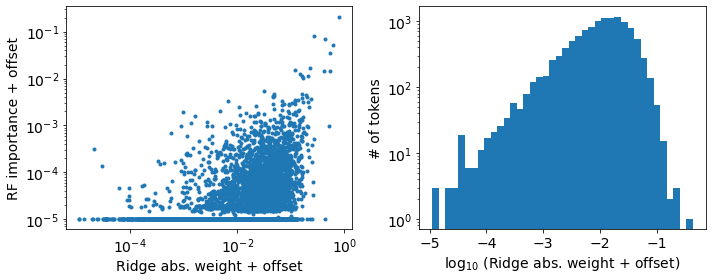

In [167]:
# Offset for plotting zero values in log scale:
offset = 1e-5
# Select only features with no importance:
no_importance = word_weight_df.loc[np.isclose(word_weight_df['importance'], 0)]

pl.figure(figsize=(10,4))

# Scatter plot - Random Forest Importance vs. Ridge abs. weights
pl.subplot(1,2,1)
pl.scatter(offset + word_weight_df['abs_weight'], offset + word_weight_df['importance'], marker='.')
pl.yscale('log')
pl.xscale('log')
pl.tick_params(labelsize=14)
pl.xlabel('Ridge abs. weight + offset', fontsize=14)
pl.ylabel('RF importance + offset', fontsize=14)

pl.subplot(1,2,2)
pl.hist(np.log10(offset + no_importance['abs_weight']), bins=40)
pl.yscale('log')
pl.tick_params(labelsize=14)
pl.xlabel(r'$\log_{10}$ (Ridge abs. weight + offset)', fontsize=14)
pl.ylabel('# of tokens', fontsize=14)

pl.tight_layout()
pl.show()

In [168]:
token_selection = word_weight_df.loc[word_weight_df['abs_weight'] >= 0.05]

In [169]:
word_weight_df.sort_values('abs_weight', ascending=False).head(20)

,word,weight,abs_weight,importance
14246,xxdascincoxx,0.804108,0.804108,0.211982
14249,xxdasseisxx,0.619937,0.619937,0.052724
6965,exonerar,0.539637,0.539637,0.035281
14244,xxcgeixx,0.529129,0.529129,0.014699
14250,xxdastresxx,-0.520169,0.520169,0.000949
10440,nomear,0.444520,0.444520,0.069315
14247,xxdasdoisxx,-0.430748,0.430748,0.000000
14254,xxfcpequatroxx,0.409451,0.409451,0.014661
7129,federativa,0.274640,0.274640,0.000514
2688,9794,0.273426,0.273426,0.080725


In [170]:
token_selection.sort_values('importance', ascending=False)['word'].values

array(['xxdascincoxx', '9794', 'nomear', ..., 'estatística',
       'estruturação', 'funai'], dtype=object)

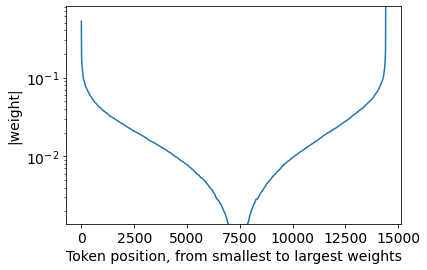

In [171]:
word_weights = word_weight_df['weight'].sort_values().values
pl.plot(np.abs(word_weights))
pl.yscale('log')
pl.ylim([20 / len(word_weights), np.max(np.abs(word_weights))])
pl.xlabel('Token position, from smallest to largest weights', fontsize=14)
pl.ylabel('|weight|', fontsize=14)
pl.tick_params(labelsize=14)
pl.show()

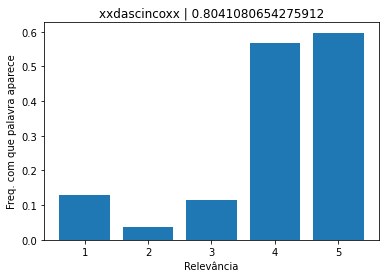

In [175]:
word_weight_pos = -1
sorted_word_weight = word_weight_df.sort_values('weight')
word = sorted_word_weight.iloc[word_weight_pos]['word']
weight = sorted_word_weight.iloc[word_weight_pos]['weight']
counts = proc_train.loc[proc_train.tit_org_ementa_text.str.contains(word)]['relevancia'].value_counts()
total  = proc_train['relevancia'].value_counts()
freq   = counts / total
pl.bar(freq.index, freq.values)
pl.title(word + ' | ' + str(weight))
pl.xlabel('Relevância')
pl.ylabel('Freq. com que palavra aparece')
pl.show()

### Identificando textos similares

Aqui nós podemos identificar os erros catastróficos do modelo e ver com quais dados do treino eles se parecem, para eventualmente detectar erros na base de dados.

#### Funções

In [133]:
from sklearn.base import clone

In [134]:
from sklearn.metrics.pairwise import euclidean_distances

def text_similarity_matrix(corpus, vectorizer, target_r2):
    output = {}
    
    # Transform corpus into a centred (zero mean for columns) 
    # matrix (rows are texts and columns are tokens):
    matrix = vectorizer.fit_transform(corpus).toarray()
    matrix_mean = matrix.mean(axis=0)
    matrix_centred = matrix - matrix_mean
    
    output['vocab'] = np.array(vectorizer.get_feature_names())
    output['mean_vector'] = matrix_mean
    output['term_matrix'] = matrix
    
    term_freq  = np.transpose(np.transpose(matrix) / np.sqrt(matrix.sum(axis=1)))
    binary_cov = term_freq.dot(term_freq.transpose())
    np.fill_diagonal(binary_cov, 0)
    output['similarity'] = binary_cov
    
    # SVD:
    #U, s, Vh  = np.linalg.svd(matrix_centred, full_matrices=False)

    #r2_by_component = np.cumsum(s**2) / np.sum(s**2)

    # Get text main features:
    #last_component = np.argmin(np.abs(r2_by_component - target_r2))
    #print('# components:', last_component)
    #text_features  = U[:, :last_component] * np.sqrt(len(matrix))
    #output['text_features'] = text_features
    
    # Compute the distance between texts:
    #output['text_distance'] = euclidean_distances(text_features)
    
    return output

In [135]:
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

In [136]:
def plot_word_vector(vocab, vector):
    """
    Plot a wordcloud for words in `vocab` with frequency given by `vector`.
    Positive frequencies are plot in blue, negative frequencias as plot in red.
    """
    
    assert np.shape(vocab) == np.shape(np.array(vector)), '`vocab` and `vector` must have the same shape.'
    assert type(vocab[0]) == str or type(vocab[0]) == np.str_, '`vocab` must be a array-like of strings.'
    
    from wordcloud import (WordCloud, get_single_color_func)
    wc = WordCloud(background_color='white', relative_scaling=0.8, include_numbers=True, width=800, height=400)

    abs_vector = np.abs(vector)
    # Set word sizes:
    word_frequencies = {word:weight for word, weight in zip(vocab, abs_vector)}
    # Define colors of words (negatives are red, positives are blue):
    plus_words  = [word for word, weight in zip(vocab, vector) if weight > 0]
    minus_words = [word for word, weight in zip(vocab, vector) if weight < 0]
    color_to_words =  {'blue': plus_words, 'red': minus_words}
    default_color  = 'grey'
    
    # Generate wordcloud:
    wc.generate_from_frequencies(word_frequencies)
    # Color words according to their signs:
    grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
    wc.recolor(color_func=grouped_color_func)
    
    #pl.figure(figsize=(12,7))
    pl.imshow(wc, interpolation="bilinear")
    pl.axis("off")

In [137]:
def build_similarity_df(train, test, vectorizer):
    """
    Compute the similarity between texts stored in `train` and 
    `test` Pandas series. To vectorize the text, it uses 
    `vectorizer` (assumed with option binary=True). The similarity 
    is the number of common tokens normalized to the geometric mean
    of the number of tokens in each text.
    
    Output: A Pandas DataFrame where the rows are train texts and 
    the columns are test texts (the indices of rows and columns are 
    the text indices).
    """
    
    # Vectorize texts:
    vec = clone(vectorizer)
    train_matrix = vec.fit_transform(train).astype(bool).astype(int)
    test_matrix  = vec.transform(test).astype(bool).astype(int)

    # Create text similarity df:
    norm_train = np.diag(1 / np.sqrt(train_matrix.sum(axis=1).A1))
    norm_test  = np.diag(1 / np.sqrt(test_matrix.sum(axis=1).A1))
    common_word_counts = train_matrix.dot(test_matrix.transpose()).toarray()
    similarity_matrix  = norm_train.dot(common_word_counts).dot(norm_test)
    similarity_df = pd.DataFrame(similarity_matrix, index=train.index, columns=test.index)
    
    return similarity_df

In [138]:
def analise_similarity_with(test_idx, train_df, test_df, similarity_df, sim_thresh, max_matches,
                            class_col='relevancia', text_col='url'):
    """
    Print information about the best matching training texts to a given test text:
    - Class, similarity and text (or link);
    - Plot of the ordered similarities above `sim_thresh` threshold;
    - Histogram of the train text classes with similarities above `sim_thresh`.
    
    Input
    -----
    
    test_idx : Pandas DataFrame index
        The index of the test text stored in `test_df`.
        
    train_df : Pandas DataFrame
        The training dataset containing the texts tested for similarity with 
        the test text.
        
    test_df : Pandas DataFrame
        The test dataset containing the test text with index given by `test_idx`.
        
    similarity_df : Pandas DataFrame
        A matrix with similarities between test texts (columns) and train texts (rows).
        Computed by the `build_similarity_df` function.
        
    sim_thresh : float
        Minimum similarity used to select texts from `train_df`.
        
    max_matches : int
        Maximum number of train texts whose information is printed. 
    """

    # Ignore self correlation if both train and test sets are the same:
    if train_df.equals(test_df):
        skip_self = 1
    else:
        skip_self = 0
    
    # Print test text info:
    print(xu.Bold('Test text') + ' (class {:d})'.format(test_df.loc[test_idx, class_col]))
    print(test_df.loc[test_idx, text_col])

    # Find most similar texts in train sample:
    test_ex_similarity = similarity_df[test_idx]
    train_best_matches = test_ex_similarity.loc[test_ex_similarity > sim_thresh].sort_values(ascending=False)
    train_best_matches = train_best_matches.iloc[skip_self:]
    train_best_matches_top = train_best_matches.head(max_matches)
    best_matches_df = train_df.loc[train_best_matches_top.index]
    
    # Print info about train text:
    print(xu.Bold('Train texts'))
    for i in best_matches_df.index:
        print('(class {:d}  sim. {:.4f})  {:s}'.format(best_matches_df.loc[i, class_col], 
                                                       train_best_matches[i], 
                                                       best_matches_df.loc[i, text_col]))
    
    pl.figure(figsize=(10,4))
    # Plot similarities above threshold:
    pl.subplot(1,2,1)
    pl.plot(train_best_matches.sort_values(ascending=False).values)
    pl.xlabel('Posição do texto de treino')
    pl.ylabel('Similaridade com texto teste')
    # Plot histogram of classes of similar texts:
    pl.subplot(1,2,2)
    sim_train_class_counts = train_df.loc[train_best_matches.index, 'relevancia'].value_counts()
    pl.bar(sim_train_class_counts.index, sim_train_class_counts.values)
    pl.xlabel('Relevância do texto de treino')
    pl.ylabel('# textos de treino')

#### Aplicação

In [176]:
from sklearn.model_selection import cross_val_predict

In [177]:
# Compute similarity between texts:
similarity_df = build_similarity_df(proc_train_val.tit_org_ementa_text, proc_train_val.tit_org_ementa_text, 
                                    vectorizer)

In [178]:
# Predict rank for all articles using cross validation:
idx = ml.shuffled_pos(len(proc_train_val), 3911)
shuffled_proc_train_val = proc_train_val.iloc[idx]
assert len(shuffled_proc_train_val) == len(proc_train_val)
y_cross_pred = cross_val_predict(fit_pipe, shuffled_proc_train_val, shuffled_proc_train_val.relevancia.values)

In [179]:
# Get validation data true values and predictions:
y_pred_true_df = pd.DataFrame({'y_pred':y_cross_pred, 'y_true': shuffled_proc_train_val['relevancia'].values}, 
                              index=shuffled_proc_train_val.index)
y_pred_true_df['diff'] = y_pred_true_df['y_pred'] - y_pred_true_df['y_true']
y_pred_true_df['abs_diff'] = np.abs(y_pred_true_df['diff'])

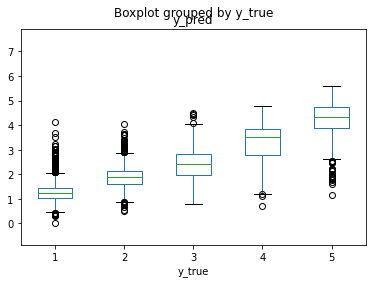

In [180]:
y_pred_true_df.boxplot(column='y_pred', by='y_true', grid=False)
pl.ylim([-0.9,7.9])
pl.show()

In [181]:
check_list = y_pred_true_df.sort_values('abs_diff', ascending=False)

Rank:  4.135
Test text (class 1)
http://www.in.gov.br/web/dou/-/decretos-de-11-de-agosto-de-2021-337823789
Train texts
(class 3  sim. 0.5791)  http://www.in.gov.br/web/dou/-/decreto-de-27-de-abril-de-2021-316371968
(class 5  sim. 0.5533)  http://www.in.gov.br/web/dou/-/decretos-de-1-de-junho-de-2021-323577685
(class 5  sim. 0.5452)  http://www.in.gov.br/web/dou/-/decreto-de-27-de-julho-de-2021-334581586
(class 5  sim. 0.5387)  http://www.in.gov.br/web/dou/-/decreto-de-11-de-agosto-de-2021-337823873
(class 5  sim. 0.5387)  http://www.in.gov.br/web/dou/-/decretos-de-5-de-agosto-de-2021-336648214
(class 5  sim. 0.5384)  http://www.in.gov.br/web/dou/-/decreto-de-27-de-julho-de-2021-334582957
(class 5  sim. 0.5309)  http://www.in.gov.br/web/dou/-/decretos-de-16-de-agosto-de-2021-338675954
(class 2  sim. 0.5249)  http://www.in.gov.br/web/dou/-/decreto-de-22-de-junho-de-2021-327333646
(class 5  sim. 0.5242)  http://www.in.gov.br/web/dou/-/decreto-de-18-de-fevereiro-de-2021-304192638
(class 4 

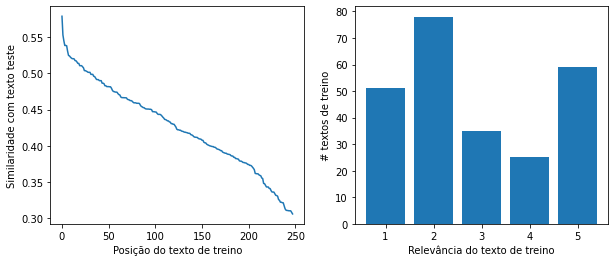

In [190]:
i = 7
print(xu.Bold('Rank: '), np.round(check_list.iloc[i]['y_pred'], 3)) 
analise_similarity_with(check_list.index[i], train_val_concat, train_val_concat, similarity_df, 0.30, 10)

### Testa no test set

In [32]:
from sklearn.metrics import mean_squared_error

In [33]:
# Preprocess data:
proc_train_val = preprocess.transform(train_val_concat)
proc_test      = preprocess.transform(test_raw)
# Fit model:
fit_pipe.fit(proc_train_val, proc_train_val.relevancia.values, fit__sample_weight=relevance2weight(proc_train_val.relevancia.values))
# Predict:
pred_train_val = fit_pipe.predict(proc_train_val)
pred_test      = fit_pipe.predict(proc_test)

In [34]:
print('RMSE:       ', np.sqrt(mean_squared_error(proc_test.relevancia.values, pred_test)))
print('Cum. Recall:', ev.cum_recall_metric(proc_test.relevancia.values, pred_test))

RMSE:        0.7206844349044502
Cum. Recall: 0.9448555074689379


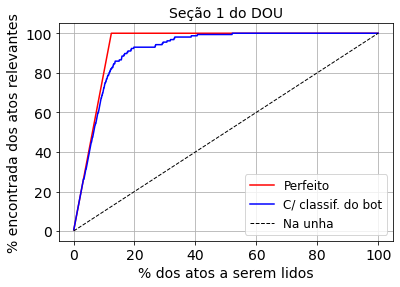

In [35]:
ev.plot_recall_curve(proc_test.relevancia.values, pred_test)

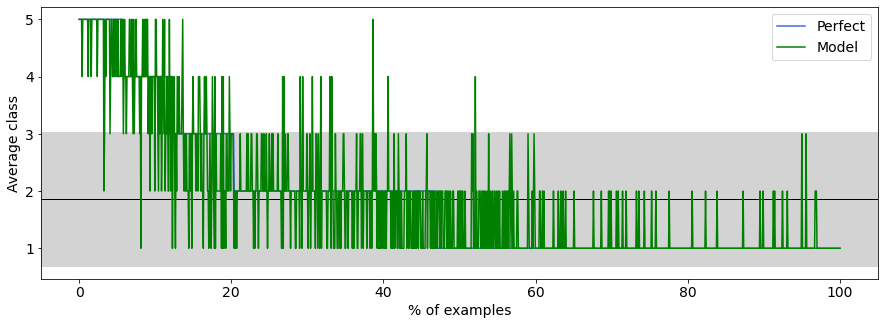

In [36]:
window = 1

pl.figure(figsize=(15,5))
ev.plot_average_rank(proc_test['relevancia'].values, proc_test['relevancia'].values, window, 
                  color='royalblue', label='Perfect')
ev.plot_average_rank(proc_test['relevancia'].values, pred_test, window, color='g', label='Model')
pl.legend(fontsize=14)
pl.show()

In [37]:
# Get validation data true values and predictions:
y_pred_true_df = pd.DataFrame({'y_pred':pred_test, 'y_true': proc_test['relevancia'].values}, 
                              index=proc_test.index)
y_pred_true_df['diff'] = y_pred_true_df['y_pred'] - y_pred_true_df['y_true']
y_pred_true_df['abs_diff'] = np.abs(y_pred_true_df['diff'])

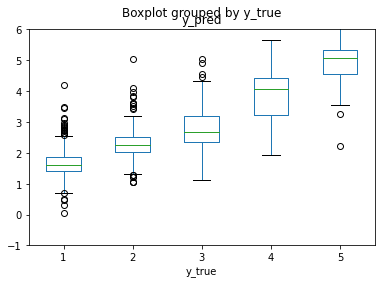

In [38]:
y_pred_true_df.boxplot(column='y_pred', by='y_true', grid=False)
#pl.savefig('plots/box-plot_rank_by_true_label_' + dt.datetime.now().strftime('%Y-%m-%d') + '.png')
pl.ylim([-1,6])
pl.show()

In [39]:
y_pred_true_df.loc[y_pred_true_df.y_true.isin([4,5])]['y_pred'].sort_values().head(10)

11164    1.936011
103      2.181855
1731     2.221205
11276    2.299253
10841    2.303501
12404    2.336898
4781     2.357757
11157    2.388516
11301    2.394722
12884    2.449505
Name: y_pred, dtype: float64

In [210]:
check_list = y_pred_true_df.sort_values('abs_diff', ascending=False)
# Compute similarity between texts:
similarity_df = build_similarity_df(proc_train_val.tit_org_ementa_text, proc_test.tit_org_ementa_text, vectorizer)

In [211]:
check_list.head()

,y_pred,y_true,diff,abs_diff
325,5.128311,2,3.128311,3.128311
8159,4.104197,1,3.104197,3.104197
1693,2.253619,5,-2.746381,2.746381
9946,3.432568,1,2.432568,2.432568
247,3.409407,1,2.409407,2.409407


Test text (class 5)
http://www.in.gov.br/web/dou/-/decretos-de-5-de-novembro-de-2020-286734673
Train texts
(class 3  sim. 0.7233)  http://www.in.gov.br/web/dou/-/decreto-de-9-de-novembro-de-2020-287258557
(class 2  sim. 0.5901)  http://www.in.gov.br/web/dou/-/decreto-de-18-de-dezembro-de-2020-295174871
(class 3  sim. 0.5839)  http://www.in.gov.br/web/dou/-/decreto-de-30-de-julho-de-2021-335463511
(class 3  sim. 0.5795)  http://www.in.gov.br/web/dou/-/decreto-de-29-de-julho-de-2021-335142083
(class 3  sim. 0.5764)  http://www.in.gov.br/web/dou/-/decreto-de-3-de-dezembro-de-2020-292123829
(class 4  sim. 0.5594)  http://www.in.gov.br/web/dou/-/decreto-de-16-de-novembro-de-2020-288552660
(class 5  sim. 0.5013)  http://www.in.gov.br/web/dou/-/decretos-de-28-de-outubro-de-2020-285619501
(class 3  sim. 0.4970)  http://www.in.gov.br/web/dou/-/decreto-de-4-de-novembro-de-2020-286531720
(class 4  sim. 0.4968)  http://www.in.gov.br/web/dou/-/decreto-de-19-de-julho-de-2021-332966409
(class 5  sim.

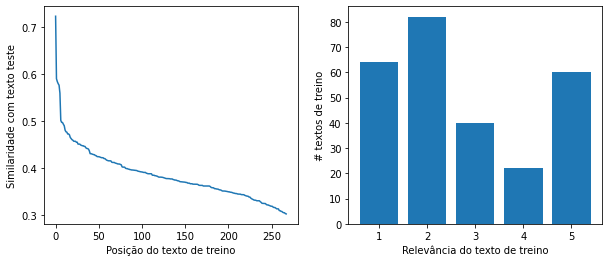

In [228]:
i = 16
analise_similarity_with(check_list.index[i], train_val_concat, test_raw, similarity_df, 0.30, 10)
print(xu.Bold('Rank: '), np.round(check_list.iloc[i]['y_pred'], 2)) 

### Reanalisando exemplos

In [93]:
#x = train_val_concat.loc[(train_val_concat.relevancia == 1) &
#                         (train_val_concat.fulltext.str.lower().str.contains(r'(?:conselho|comitê|grupo de trabalho)'))]
#len(x)

x = classified_secao.loc[(classified_secao.relevancia == 5) &
                         (classified_secao.fulltext.str.contains(r'DAS[ -]*?[0123]{3}\.4'))]
len(x)

16

In [95]:
i = 2
print(x.iloc[i]['orgao'])
print('')
print(x.iloc[i]['ementa'])
print('')
print(x.iloc[i]['fulltext'])
print('')
print(x.iloc[i]['url'])

Ministério da Mulher, da Família e dos Direitos Humanos/Secretaria Executiva

None

O SECRETÁRIO-EXECUTIVO DO MINISTÉRIO DA MULHER, DA FAMÍLIA E DOS DIREITOS HUMANOS, no uso de suas atribuições conferidas pela Portaria nº 160, de 07 de março de 2018, publicada no Diário Oficial da União de 9 de março de 2018, e tendo em vista o disposto na Medida Provisória nº 870, de 1º de janeiro de 2019, e no Decreto nº 9.673, de 2 de janeiro de 2019, resolve: Nº 478 - Exonerar, a pedido, DANYEL IÓRIO DE LIMA, do cargo de Coordenador-Geral de Políticas Temáticas da Secretaria Nacional dos Direitos da Criança e do Adolescente deste Ministério, código DAS 101.4.Nº 479 - Exonerar NATÁLIA DE PAIVA MORAES MOREIRA do cargo de Assessor da Secretaria Nacional da Juventude deste Ministério, código DAS 102.4.Nº 480 - Nomear MARIA EDUARDA DINARDI MARDEGAN, para exercer o cargo de Assessor da Secretaria Nacional da Juventude deste Ministério, código DAS 102.4.Nº 481 - Dispensar FILIPE TRIGUEIRO XAVIER CORREIA d

## Colocando em produção

### Cria modelo de teste para registro

In [315]:
# Fit to train and validation set; test on test set:
#final_test_pipeline = do.create_model_sec2()
#dump = final_test_pipeline.fit(train_val_concat, train_val_concat.relevancia.values, fit__sample_weight=relevance2weight(train_val_concat.relevancia.values))
# Predict:
#y_test_pred = final_test_pipeline.predict(test_raw)
# Evaluate:
#test_score  = ev.cum_recall_metric(test_raw.relevancia.values, y_test_pred)
#print('RMSE:       ', np.sqrt(mean_squared_error(test_raw.relevancia.values, y_test_pred)))
#print('Cum. Recall:', test_score)

In [40]:
# Create and fit model to train data:
final_test_pipeline = do.create_model_sec2()
dump = final_test_pipeline.fit(train_raw, train_raw.relevancia.values, fit__sample_weight=relevance2weight(train_raw.relevancia.values))

In [41]:
# Predict:
y_train_pred = final_test_pipeline.predict(train_raw) 
y_val_pred   = final_test_pipeline.predict(val_raw)
y_test_pred  = final_test_pipeline.predict(test_raw)
# Evaluate:
train_score  = ev.cum_recall_metric(train_raw.relevancia.values, y_train_pred)
val_score    = ev.cum_recall_metric(val_raw.relevancia.values,  y_val_pred)
test_score   = ev.cum_recall_metric(test_raw.relevancia.values,  y_test_pred)
print(xu.Bold('Val'))
print('RMSE:       ', np.sqrt(mean_squared_error(val_raw.relevancia.values, y_val_pred)))
print('Cum. Recall:', val_score)
print(xu.Bold('Test'))
print('RMSE:       ', np.sqrt(mean_squared_error(test_raw.relevancia.values, y_test_pred)))
print('Cum. Recall:', test_score)

Val
RMSE:        0.7022323828536192
Cum. Recall: 0.9459416468342579
Test
RMSE:        0.7144735729185285
Cum. Recall: 0.9478570431383498


### Cria modelo de produção

In [42]:
# Create and fit model to train data:
final_prod_pipeline = do.create_model_sec2()
dump = final_prod_pipeline.fit(classified_secao, classified_secao.relevancia.values, fit__sample_weight=relevance2weight(classified_secao.relevancia.values))

### Salva resultados

In [43]:
#ml.save_model('../modelos/dou-2_sorter_ensemble_2021-09-17/', final_test_pipeline, final_prod_pipeline, 
#              train_raw, test_raw, 'cum_recall_metric', train_score, test_score, val_df=val_raw)

### Testando modelo em produção

In [44]:
import joblib
from sklearn.metrics import mean_squared_error
# Model evaluation:
import dou_model_eval as ev

In [49]:
# Load test data:
loaded_test_data = pd.read_csv('../modelos/dou-2_sorter_ensemble_2021-09-17/test_data.csv')

In [55]:
# Get predictions from saved tested model:
loaded_model  = joblib.load('../modelos/dou-2_sorter_ensemble_2021-09-17/tested_model.joblib')
#loaded_model  = joblib.load('../modelos/dou-2_sorter_ensemble_2020-07-25/production_model.joblib')
#loaded_model = joblib.load('../modelos/dou-2_sorter_ensemble_2020-06-08/tested_model.joblib')
y_pred_loaded = loaded_model.predict(loaded_test_data)

#### Métricas de avaliação

In [56]:
print('RMSE:       ', np.sqrt(mean_squared_error(loaded_test_data.relevancia, y_pred_loaded)))
print('Cum. Recall:', ev.cum_recall_metric(loaded_test_data.relevancia.values, y_pred_loaded))

RMSE:        0.7144735729185285
Cum. Recall: 0.9478570431383498


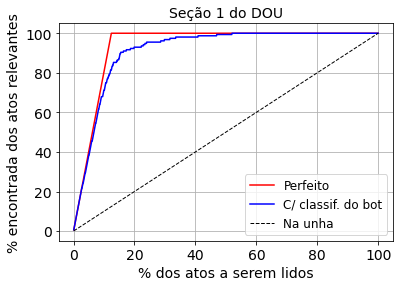

In [57]:
ev.plot_recall_curve(loaded_test_data.relevancia.values, y_pred_loaded)

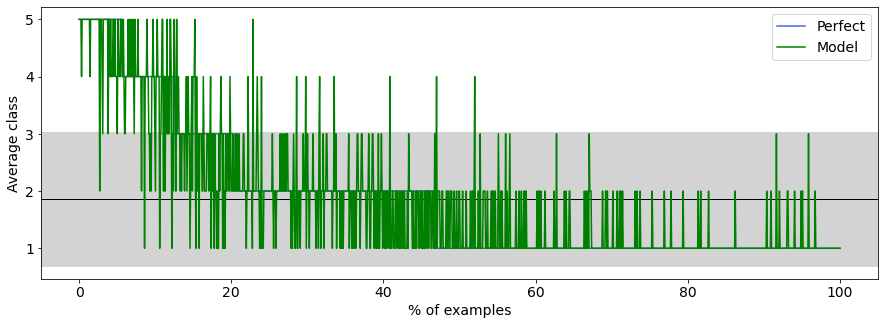

In [58]:
window = 1

pl.figure(figsize=(15,5))
ev.plot_average_rank(loaded_test_data['relevancia'].values, loaded_test_data['relevancia'].values, window, 
                  color='royalblue', label='Perfect')
ev.plot_average_rank(loaded_test_data['relevancia'].values, y_pred_loaded, window, color='g', label='Model')
pl.legend(fontsize=14)
pl.show()

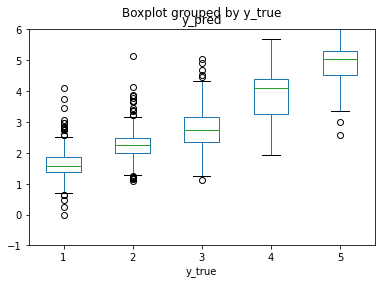

In [59]:
# Join validation true and predicted values:
y_pred_true_loaded_df = pd.DataFrame({'y_pred':y_pred_loaded, 'y_true': loaded_test_data['relevancia'].values}, 
                                     index=loaded_test_data.index)
y_pred_true_loaded_df.boxplot(column='y_pred', by='y_true', grid=False)
#pl.savefig('plots/box-plot_rank_by_true_label_' + dt.datetime.now().strftime('%Y-%m-%d') + '.png')
pl.ylim([-1,6])
pl.show()

## Reclassificando matérias com DAS 4

In [37]:
old_articles = classified_secao.loc[classified_secao.data_pub < '2020-06-15']

In [38]:
das4_articles = old_articles.loc[old_articles.fulltext.str.contains('DAS[ -]*?[0123]{3}\.4')]

In [45]:
high_das4_articles = das4_articles.loc[das4_articles.relevancia >= 3]

In [46]:
#high_das4_articles.to_csv('../dados/artigos_sec2_com_das4_relevancia_3+.csv', index=False)

## Construindo amostra de treinamento representativa

### Carrega matérias da seção 2 do DOU, com cortes e antes de 2020-04-25

In [28]:
sample_query = """
SELECT 
  NULL AS relevancia, identifica, orgao, ementa, resumo, 
  IF(LENGTH(clean_text) > 49990, CONCAT(SUBSTR(clean_text, 1, 49990), '...'), clean_text) AS fulltext, 
  secao, edicao, pagina, data_pub, assina, cargo, url, url_certificado

FROM `gabinete-compartilhado.testing_mess.artigos_dou_cleaned_ate_2020_06_02`  

-- Restringe a matérias ainda não classificadas:
WHERE url NOT IN (
  SELECT url 
  FROM `gabinete-compartilhado.executivo_federal_dou.artigos_classificados` 
  WHERE url IS NOT NULL
)
-- Restringe a datas de treinamento:
AND data_pub < '2020-04-25'

-- Corte feito nas matérias da seção 2:
AND secao = 2
AND (LOWER(orgao) NOT LIKE '%universidade%' AND LOWER(orgao) NOT LIKE '%instituto federal%')
AND (LOWER(orgao) NOT LIKE '%superintendência regional%')
AND (LOWER(orgao) NOT LIKE '%gerência regional%')
AND (LOWER(orgao) NOT LIKE '%superintendência estadual%' AND LOWER(orgao) NOT LIKE '%colégio%')
AND SPLIT(orgao, '/')[OFFSET(0)] 
  NOT IN ('Conselho Nacional do Ministério Público', 
          'Entidades de Fiscalização do Exercício das Profissões Liberais', 'Governo do Estado', 'Ineditoriais', 
          'Defensoria Pública da União', 'Ministério Público da União', 'Poder Judiciário', 'Prefeituras', 
          'Tribunal de Contas da União', 'Atos do Poder Judiciário', 'Poder Legislativo')
AND orgao 
  NOT IN ('Conselho Nacional do Ministério Público', 
          'Entidades de Fiscalização do Exercício das Profissões Liberais', 'Governo do Estado', 'Ineditoriais', 
          'Defensoria Pública da União', 'Ministério Público da União', 'Poder Judiciário', 'Prefeituras', 
          'Tribunal de Contas da União', 'Atos do Poder Judiciário', 'Poder Legislativo')
AND (LOWER(orgao) NOT LIKE '%comando militar%')
AND (LOWER(orgao) NOT LIKE '%hospital%')
AND LOWER(fulltext) NOT LIKE '%conceder aposentadoria%' AND LOWER(fulltext) NOT LIKE '%aposentar%'
AND LOWER(fulltext) NOT LIKE '%conceder pensão%' 
AND LOWER(fulltext) NOT LIKE '%afastamento do país%'
"""

In [29]:
sample_raw = xu.load_data_from_local_or_bigquery(sample_query, 
                                                 '../dados/amostra_secao_2_com_cortes_ate_2020-04-25.csv')

Loading data from local file...


In [30]:
print('# examples:', len(sample_raw))

# examples: 30217


### Criando exemplos sintéticos

Este processo foi testado e concluímos que ele não introduz variabilidade o suficiente para ser útil (i.e. melhorar a performance do modelo), de maneira que ele foi abandonado.

In [214]:
sel = sample_raw.loc[(sample_raw.fulltext.str.lower().str.contains(r'nomear'))]
i = 7
print(sel.iloc[i].identifica)
print('')
print(sel.iloc[i].orgao)
print('')
print(sel.iloc[i].ementa)
print('')
print(sel.iloc[i].fulltext)
print('')
print(sel.iloc[i].url)


PORTARIA Nº 208-DGP/DCIPAS, DE 23 DE DEZEMBRO DE 2019

Ministério da Defesa/Comando do Exército/Departamento-Geral do Pessoal/Diretoria de Civis, Inativos, Pensionistas e Assistência Social

nan

O CHEFE DO DEPARTAMENTO-GERAL DO PESSOAL, no uso da competência que lhe foi conferida pela Portaria nº 218-Comandante do Exército, de 20 de março de 2017, resolve:Exonerar,ex officio, o Terceiro Sargento da Reserva Remunerada (Idt: 114239503-5) EDNALDO DOS ANJOS DE JESUS, Prec-CP: 96 1634328, da Diretoria de Civis, Inativos, Pensionistas e Assistência Social (BRASÍLIA-DF), a partir de 1º de janeiro de 2020, de acordo com a alínea a), do inciso II, do Art 11, da Portaria nº 218-Comandante do Exército, de 20 de março de 2017, de Prestador de Tarefa por Tempo Certo.Nomear,por proposta do Diretor de Civis, Inativos, Pensionistas e Assistência Social, o Terceiro Sargento da Reserva Remunerada (Idt: 114239503-5) EDNALDO DOS ANJOS DE JESUS, Prec-CP: 96 1634328, na Diretoria de Civis, Inativos, Pensio

In [215]:
atos_model_raw = pd.read_csv('../dados/atos_para_gerar_exemplos_sinteticos.csv')

In [217]:
import spacy

ModuleNotFoundError: No module named 'spacy'

### Cluster

In [31]:
from sklearn.cluster import KMeans

In [46]:
# Data vectorizer:
cluster_vectorizer = CountVectorizer(lowercase=False, binary=True, ngram_range=(1,1))
cluster_extra      = OneHotEncoder(drop='first')
cluster_processor  = ColumnTransformer([('vec',   cluster_vectorizer, 'tit_org_ementa_text'),
                                        ('extra', cluster_extra, ['tipo_edicao'])])

cluster_prepare    = Pipeline([('pre', preprocess), ('proc', cluster_processor)])

In [47]:
# Vectorize texts:
sample_X = cluster_prepare.fit_transform(sample_raw)
print('Term-document matrix shape:', sample_X.shape)

In [49]:
# Cluster texts:
kmeans = KMeans(n_clusters=100, n_jobs=7)
dump = kmeans.fit(sample_X)
cluster_distances = kmeans.transform(sample_X)
cluster_labels = kmeans.labels_

In [62]:
# Find most representative texts for each cluster:
near_center_idx = np.argmin(cluster_distances, axis=0)

In [150]:
#sample_raw.iloc[near_center_idx].to_csv('dou_2_100_clusters_representatives_2020-06-20.csv', index=False)

In [103]:
# Exemplos de matérias num cluster:
k = 5
sample_raw.iloc[cluster_labels == k][['identifica', 'orgao', 'fulltext']].sample(5)

,identifica,orgao,fulltext
24319,"PORTARIA Nº 10, DE 3 DE MARÇO DE 2020",Ministério do Desenvolvimento Regional/Gabinet...,O CORREGEDOR DO MINISTÉRIO DO DESENVOLVIMENTO ...
7351,"Portaria Nº 432, de 29 de novembro de 2019",Ministério da Infraestrutura/Empresa de Planej...,O Diretor-Presidente Substituto da Empresa de ...
15553,"PORTARIA Nº 5.533, DE 2 DE MAIO DE 2019",Ministério da Saúde/Fundação Oswaldo Cruz,A Presidente da Fundação Oswaldo Cruz - FIOCRU...
26423,"PORTARIA Nº 497, DE 11 DE MARÇO DE 2020",Ministério da Economia/Secretaria Especial da ...,O SECRETÁRIO ESPECIAL DA RECEITA FEDERAL DO BR...
19676,"PORTARIA Nº 35, DE 29 DE JANEIRO DE 2020",Ministério da Cidadania/Corregedoria-Geral,"O CORREGEDOR-GERAL DO MINISTÉRIO DA CIDADANIA,..."


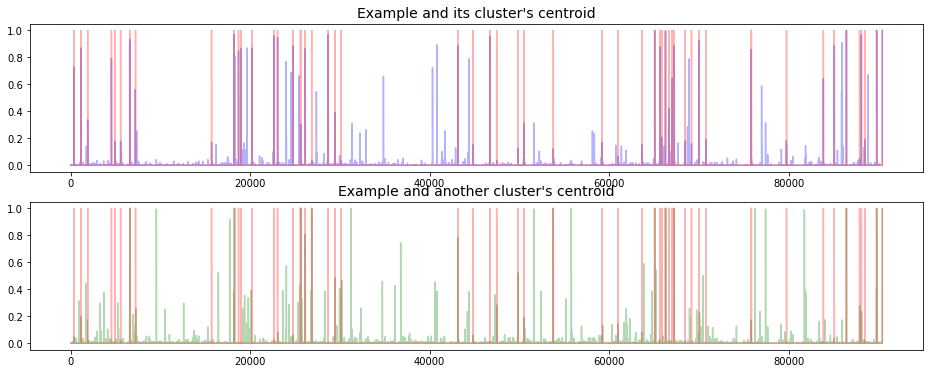

In [148]:
# Plot cluster member and centroid (components):
k = 1 # Cluster number

k_cluster_idx = np.where(cluster_labels == k)[0]
k_cluster_X   = sample_X[k_cluster_idx]
k_cluster_ex  = k_cluster_X[np.random.randint(0, len(k_cluster_idx))].toarray()[0]

pl.figure(figsize=(16,6))
pl.subplot(2,1,1)
pl.title("Example and its cluster's centroid", fontsize=14)
pl.plot(kmeans.cluster_centers_[k], alpha=0.3, color='b')
pl.plot(k_cluster_ex, alpha=0.3, color='r')
pl.subplot(2,1,2)
pl.title("Example and another cluster's centroid", fontsize=14)
pl.plot(kmeans.cluster_centers_[k+1], alpha=0.3, color='g')
pl.plot(k_cluster_ex, alpha=0.3, color='r')
#pl.plot(kmeans.cluster_centers_[3], alpha=0.5)
pl.show()

# Lixo

### Teste de redução de dimensionalidade

In [ ]:
# Check if there is any word that appears in every text:
vec1 = clone(vectorizer)
bin_train = vec1.fit_transform(proc_train.tit_org_ementa_text).toarray()


np.all(np.prod(bin_train, axis=0) == 0)

In [ ]:
bin_train.shape

### Outras coisas

In [ ]:
def array_derivative(y, x=None):
    """
    Given an array `y` and and optional array `x`, compute the derivative
    dy / dx (x = [0,1,...,N-1] if unespecified, where N = len(y)). The 
    derivative value is attributed to the initial point used in the calculation,
    and the final value is extrapolated from the last two points in x and y.
    """
    if x != None:
        dx = np.diff(x)
        assert np.all(np.isclose(dx, np.ones(len(dx)) * dx[0])), 'x should be linearly spaced.'
        dx = np.append(dx, dx[-1])
    dy = np.diff(y)
    # Extrapolate derivative
    dy = np.append(dy, [dy[-1] + dy[-1] - dy[-2]])
    if x == None:
        return dy
    else:
        return dy / dx

# Anotações sobre python

#### Invertendo um dicionário

In [ ]:
{w:k for k,w in class_to_weight.items()}

#### Usando `*args` e `**kwargs`

Dentro da função, o `arg` de `*arg` é tratado como uma tupla.

In [ ]:
def teste(x, *arg):
    print(x)
    for a in arg:
        print(a)
    print(arg)
    print(type(arg))

In [ ]:
teste(1, 'aba', 't', -1)

In [ ]:
teste(1, *(10,20,30))

`kmargs` significa **k**ey**w**ord arguments. Dentro da função, o `kwargs` é tratado como dicionário.

In [ ]:
def teste(x, **kwargs):
    print(x)
    print(kwargs)
    print(type(kwargs))
    print(kwargs['abacate'])

In [ ]:
teste(1, abacate=2, felix='coco', blob=1000)

In [ ]:
teste(1, **{'abacate':1, 'y':2})

In [263]:
st_month = 1
st_year = 2014
end_month = 12
end_year = 2014
        
while st_year * 12 + st_month <= end_year * 12 + end_month:     
    print(st_month, st_year)
    st_month+=1
    if st_month == 13:
        st_month=1
        st_year+=1

1 2014
2 2014
3 2014
4 2014
5 2014
6 2014
7 2014
8 2014
9 2014
10 2014
11 2014
12 2014
